In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
# we will use: Random forest, XGBoost and Logistic regression
# import models:
from sklearn.tree import DecisionTreeClassifier , plot_tree
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier


from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline

# import models.
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC 

In [86]:
data = pd.read_csv("C:/Users/elon6/Desktop/פרויקט גמר/מחודש/data-06.csv")


In [87]:
data

,gender,year_of_birth,Average_num_of_attempts,Sum_of_attempts,active,time_in_system,attem_rate,finish,average_time_difference,sd_time_difference,sd_time_difference_attem,SeasonNumber,date_joined_year,date_joined_month,date_joined_day,last_login_year,last_login_month,last_login_day,age
0,1,1991,1.667,20,1,1796,0.953737,1,1.886943e+00,451.535799,592.455183,1,2018,2,15,2023,1,16,3
1,1,1984,1.227,27,1,1792,0.896226,1,-7.513642e-02,515.952554,422.746167,1,2018,2,15,2023,1,12,4
2,1,1991,1.571,11,1,723,0.787879,0,2.050110e-05,0.005465,0.003846,2,2018,3,26,2020,3,18,3
3,1,1990,1.471,125,1,1016,0.538462,0,1.757629e-01,234.965974,26.240474,2,2018,4,16,2021,1,26,4
4,1,1962,1.500,3,1,1530,0.953488,0,9.428632e-06,199.332965,0.000000,2,2018,4,18,2022,6,26,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11017,1,1976,6.193,997,1,275,0.302905,1,6.639816e-03,29.019659,14.370422,2,2022,4,8,2023,1,8,5
11018,1,1988,1.318,29,1,7,0.489796,0,1.984252e-04,7.728167,6.741946,2,2022,4,20,2022,4,27,4
11019,1,2006,0.000,0,0,10,1.000000,0,2.292535e-07,0.000037,0.000000,3,2022,6,27,2022,7,7,2
11020,1,1993,1.667,10,1,1,0.714286,0,-7.410053e-01,9.944925,9.941341,3,2022,7,15,2022,7,16,3


In [88]:
hypergrid = {
    'rf':{
        'randomforestclassifier__n_estimators':[10,50,100,130],
        'randomforestclassifier__criterion':['gini', 'entropy'],
        'randomforestclassifier__max_depth':range(2,4,1),
        'randomforestclassifier__min_samples_split':[2,3,4,5,6],
        'randomforestclassifier__min_samples_leaf':[1,2,3,4,5,6],
        'randomforestclassifier__max_features':['auto', 'log2']
    },
    'decisiontreeclassifier':{
        'decisiontreeclassifier__max_depth': [2,4,6,8],
        'decisiontreeclassifier__min_samples_split': [2,4,6,8]
    },
    'ovo_logistic':{  
    },
    'xgb':{
        'xgbclassifier__learning_rate':[0.001,0.005,0.01,0.05,0.1,0.5,0.99],
        'xgbclassifier__max_depth':[3,5,10,20],
        'xgbclassifier__n_estimators':[10,50,100,200]
    },
    'ridge':{
        'ridgeclassifier__alpha':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 0.99]
    },
    'svc':{
        'svc__gamma':['scale', 'auto']
    }
}

In [53]:
X = data.drop('finish', axis=1)
y = data['finish']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [89]:
# Create a pipeline to perform SMOTE oversampling followed by Tomek Links undersampling
resampling = Pipeline([
    ('smote', SMOTE(sampling_strategy=0.7, random_state=42)),
    ('tomek', TomekLinks(sampling_strategy='majority'))
])

In [90]:
# Apply the resampling
X_resampled, y_resampled = resampling.fit_resample(X_train, y_train)

In [91]:
value_counts = y_test.value_counts()
value_counts

0    1973
1     232
Name: finish, dtype: int64

In [92]:
value_counts = y_resampled.value_counts()
value_counts

0    7833
1    5520
Name: finish, dtype: int64

In [93]:
# creating the pipline for running the different models.
piplines = {
    'decisiontreeclassifier':make_pipeline(DecisionTreeClassifier()),
    'xgb':make_pipeline(XGBClassifier(objective='binary:logistic')),
    'ovo_logistic':make_pipeline(OneVsOneClassifier(LogisticRegression(solver='sag', random_state=1234))),
#    'ridge':make_pipeline(RidgeClassifier(random_state=1234)),
    'svc':make_pipeline(SVC()),
    'rf':make_pipeline(RandomForestClassifier(random_state=1234)),

}

In [94]:
from sklearn.model_selection import GridSearchCV

fit_models = {}
scores = []

for algo, pipline in piplines.items():
    # run grid search to find best hyper parameters with K-folds cross validation (K=10)
    print(pipline)
    print(hypergrid[algo])
    model = GridSearchCV(pipline, hypergrid[algo], cv=10, n_jobs=-1)
    
    try:
        print("starting training for {}".format(algo))
        model.fit(X_resampled, y_resampled)
        fit_models[algo] = model
        print("{} trained succefully!".format(algo))
        scores.append({
            'model_name': algo,
            'best_score': model.best_score_, # average f1-score for each model in the cross validation. 
            'best_params': model.best_params_
        })
    except NotFittedError as e:
        print(repr(e))
    except Exception as e:
        print(e)
        print(repr(e))

Pipeline(steps=[('decisiontreeclassifier', DecisionTreeClassifier())])
{'decisiontreeclassifier__max_depth': [2, 4, 6, 8], 'decisiontreeclassifier__min_samples_split': [2, 4, 6, 8]}
starting training for decisiontreeclassifier
decisiontreeclassifier trained succefully!
Pipeline(steps=[('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, 

C:\Users\elon6\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


ovo_logistic trained succefully!
Pipeline(steps=[('svc', SVC())])
{'svc__gamma': ['scale', 'auto']}
starting training for svc
svc trained succefully!
Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(random_state=1234))])
{'randomforestclassifier__n_estimators': [10, 50, 100, 130], 'randomforestclassifier__criterion': ['gini', 'entropy'], 'randomforestclassifier__max_depth': range(2, 4), 'randomforestclassifier__min_samples_split': [2, 3, 4, 5, 6], 'randomforestclassifier__min_samples_leaf': [1, 2, 3, 4, 5, 6], 'randomforestclassifier__max_features': ['auto', 'log2']}
starting training for rf
rf trained succefully!


In [95]:
data_models = pd.DataFrame(scores)
data_models[['model_name','best_score']].sort_values(['best_score'],ascending=False)

,model_name,best_score
1,xgb,0.959041
0,decisiontreeclassifier,0.906916
4,rf,0.876510
3,svc,0.839957
2,ovo_logistic,0.771588


In [96]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, auc, roc_curve

In [97]:
from sklearn.metrics import accuracy_score


In [98]:
# predicting and extracting:
# accuracy, recall, precision, f1-score, AUC
results=[]
for algo, model in fit_models.items():
    predictions = model.predict(X_test)
    results.append({
        'algo':algo,
        'yhat':predictions,
        'acc':accuracy_score(y_test, predictions),
        'conf_mat':confusion_matrix(y_test, predictions, labels=model.classes_),
        'prf_weighted':precision_recall_fscore_support(y_test, predictions, average='weighted'),
        'dis_classes':model.classes_
    })
    

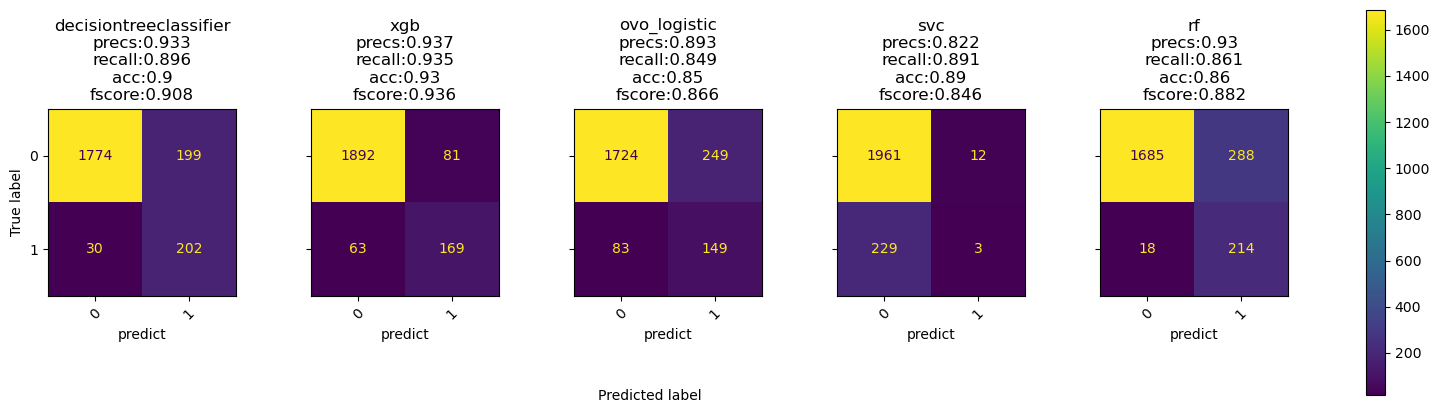

In [99]:
# visualizing the confusion matrix: 
f, axes = plt.subplots(1, 5, figsize=(20, 5), sharey='row')
for i, res in enumerate(results):
    algo, yhat, conf_mat, dis_classes=res['algo'], res['yhat'], res['conf_mat'],res['dis_classes']
    prec, recall, fscore = res['prf_weighted'][0],res['prf_weighted'][1],res['prf_weighted'][2]
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=dis_classes)
    acc = res['acc']
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(f"{algo}\nprecs:{round(prec,3)}\nrecall:{round(recall,3)}\nacc:{round(acc,2)}\nfscore:{round(fscore,3)}" )
    
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('predict')
    if i!=0:
        disp.ax_.set_ylabel('')


f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

In [100]:
scores

[{'model_name': 'decisiontreeclassifier',
  'best_score': 0.9069162237323105,
  'best_params': {'decisiontreeclassifier__max_depth': 8,
   'decisiontreeclassifier__min_samples_split': 2}},
 {'model_name': 'xgb',
  'best_score': 0.9590407948148647,
  'best_params': {'xgbclassifier__learning_rate': 0.5,
   'xgbclassifier__max_depth': 10,
   'xgbclassifier__n_estimators': 200}},
 {'model_name': 'ovo_logistic',
  'best_score': 0.7715877794971855,
  'best_params': {}},
 {'model_name': 'svc',
  'best_score': 0.8399566036466393,
  'best_params': {'svc__gamma': 'auto'}},
 {'model_name': 'rf',
  'best_score': 0.8765098454775841,
  'best_params': {'randomforestclassifier__criterion': 'gini',
   'randomforestclassifier__max_depth': 3,
   'randomforestclassifier__max_features': 'auto',
   'randomforestclassifier__min_samples_leaf': 6,
   'randomforestclassifier__min_samples_split': 2,
   'randomforestclassifier__n_estimators': 100}}]

In [101]:
from sklearn.metrics import f1_score


In [104]:
# Define a range of max_depth values
max_depth_values = range(1, 8)

# Initialize variables to store the best max_depth and its corresponding performance
best_max_depth = None
best_f1_score = 0.0

# Iterate over the max_depth values
for max_depth in max_depth_values:
    # Create and train the decision tree model
    clf = DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X_resampled, y_resampled)
    
    # Predict on the resampled data
    y_pred = clf.predict(X_resampled)
    
    # Calculate F1-score
    f1 = f1_score(y_resampled, y_pred)
    
    # Check if this max_depth gives a better F1-score
    if f1 > best_f1_score:
        best_f1_score = f1
        best_max_depth = max_depth

# Print the best max_depth and its corresponding F1-score
print("Best max_depth:", best_max_depth)
print("Best F1-score:", best_f1_score)

Best max_depth: 7
Best F1-score: 0.9067402172039304


###### For best max_depth: 3 Best F1-score: 0.8617484990541985
###### For best max_depth: 8 Best F1-score: 0.9067402172039304

In [105]:
X_resampled.columns.tolist()

['gender',
 'year_of_birth',
 'Average_num_of_attempts',
 'active',
 'time_in_system',
 'attem_rate',
 'average_time_difference',
 'sd_time_difference',
 'sd_time_difference_attem',
 'SeasonNumber',
 'date_joined_year',
 'date_joined_month',
 'date_joined_day',
 'last_login_year',
 'last_login_month',
 'last_login_day',
 'age',
 'when']

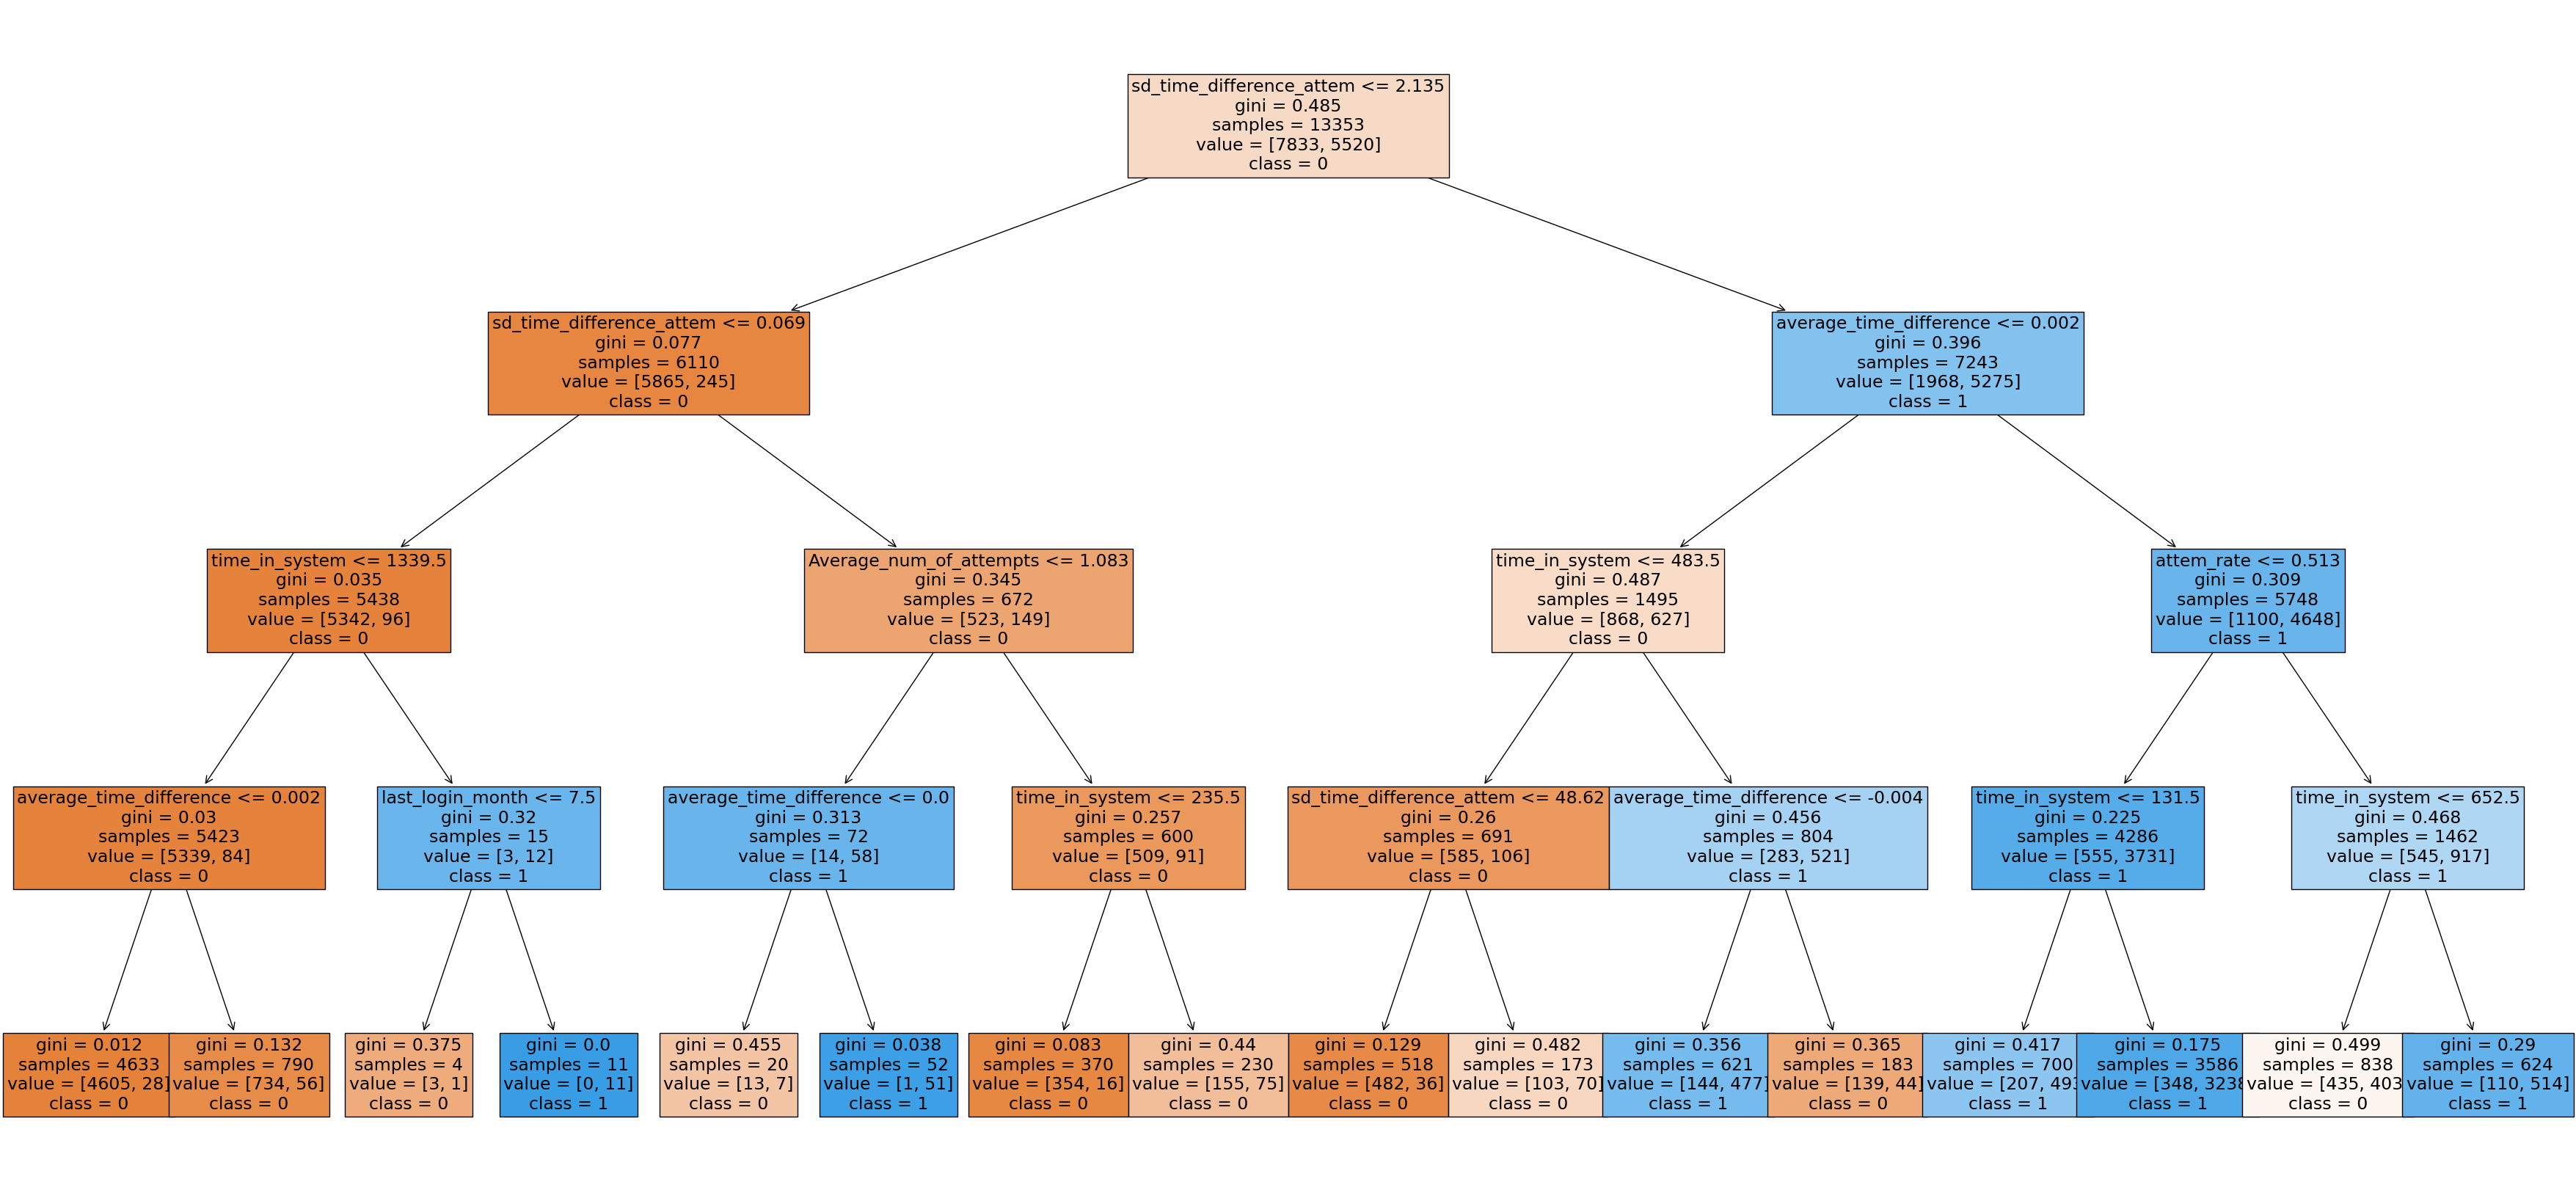

In [106]:
clf = DecisionTreeClassifier(max_depth=4, min_samples_split=2)
clf.fit(X_resampled, y_resampled)

# Modify the matplotlib settings
plt.rcParams['lines.linewidth'] = 2  # Adjust the line width
plt.rcParams['lines.markersize'] = 10  # Adjust the marker size

# Plot the decision tree
fig = plt.figure(figsize=(45, 21))
_ = plot_tree(clf,
              filled=True,
              feature_names=X.columns,
              class_names=['0', '1'],
              fontsize=17  # Adjust the font size of the text
              )
plt.show()



In [60]:
data

,gender,year_of_birth,Average_num_of_attempts,active,time_in_system,attem_rate,finish,average_time_difference,sd_time_difference,sd_time_difference_attem,SeasonNumber,date_joined_year,date_joined_month,date_joined_day,last_login_year,last_login_month,last_login_day,age,when
0,1,1991,1.667,1,1796,0.953737,1,1.886943e+00,451.535799,592.455183,1,2018,2,15,2023,1,16,3,0
1,1,1984,1.227,1,1792,0.896226,1,-7.513642e-02,515.952554,422.746167,1,2018,2,15,2023,1,12,4,0
2,1,1991,1.571,1,723,0.787879,0,2.050110e-05,0.005465,0.003846,2,2018,3,26,2020,3,18,3,0
3,1,1990,1.471,1,1016,0.538462,0,1.757629e-01,234.965974,26.240474,2,2018,4,16,2021,1,26,4,0
4,1,1962,1.500,1,1530,0.953488,0,9.428632e-06,199.332965,0.000000,2,2018,4,18,2022,6,26,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11017,1,1976,6.193,1,275,0.302905,1,6.639816e-03,29.019659,14.370422,2,2022,4,8,2023,1,8,5,0
11018,1,1988,1.318,1,7,0.489796,0,1.984252e-04,7.728167,6.741946,2,2022,4,20,2022,4,27,4,0
11019,1,2006,0.000,0,10,1.000000,0,2.292535e-07,0.000037,0.000000,3,2022,6,27,2022,7,7,2,0
11020,1,1993,1.667,1,1,0.714286,0,-7.410053e-01,9.944925,9.941341,3,2022,7,15,2022,7,16,3,0
